# Milestone 1

# 1. Environment Setup & Dependencies

In [ ]:
import os
import sys
import subprocess

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install core dependencies
install_package("ultralytics")
install_package("roboflow")
install_package("matplotlib")
install_package("opencv-python-headless")
install_package("pandas")
install_package("seaborn") # For nicer EDA plots

# Imports
import cv2
import yaml
import torch
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from ultralytics import YOLO
from roboflow import Roboflow

# Notebook settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_colwidth', None)

# System checks
print(f"Python version: {sys.version.split()[0]}")
print(f"Torch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    DEVICE = 0
else:
    print("No GPU detected. Training will be slow on CPU.")
    DEVICE = 'cpu'

Installing ultralytics...
Installing roboflow...
Installing opencv-python-headless...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Python version: 3.12.12
Torch version: 2.9.0+cpu
No GPU detected. Training will be slow on CPU.


# 2. Configuration & Reproducibility

In [ ]:
class Config:
    # Data
    API_KEY = "ffmoeLYtfHCHknfTSk9o" # Roboflow API Key from your snippet
    WORKSPACE = "imit-h5ows"
    PROJECT = "soil-detection-l0ngo"
    VERSION = 3

    # Training
    MODEL_SIZE = "l" # n, s, m, l, x (nano is fastest, large is most accurate)
    EPOCHS = 50
    BATCH_SIZE = 16
    IMG_SIZE = 640
    OPTIMIZER = 'auto'
    SEED = 42

    # Paths
    ROOT_DIR = os.getcwd()
    DATASET_DIR = os.path.join(ROOT_DIR, "Soil-detection-3") # Folder name based on Roboflow version

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.SEED)
print("Configuration loaded and random seeds set.")

Configuration loaded and random seeds set.


#  3. Data Acquisition

In [ ]:
if not os.path.exists(Config.DATASET_DIR):
    print("Downloading dataset...")
    rf = Roboflow(api_key=Config.API_KEY)
    project = rf.workspace(Config.WORKSPACE).project(Config.PROJECT)
    version = project.version(Config.VERSION)
    dataset = version.download("yolov8")
else:
    print(f"Dataset found at {Config.DATASET_DIR}. Skipping download.")

# Verify critical files
yaml_path = os.path.join(Config.DATASET_DIR, "data.yaml")
if not os.path.exists(yaml_path):
    raise FileNotFoundError(f"data.yaml not found at {yaml_path}. Dataset download may have failed.")

print(f"Dataset ready at: {Config.DATASET_DIR}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-detection-3 in yolov8:: 100%|██████████| 582/582 [00:00<00:00, 7273.10it/s]

Dataset ready at: /content/Soil-detection-3


# 4. Exploratory Data Analysis (EDA)

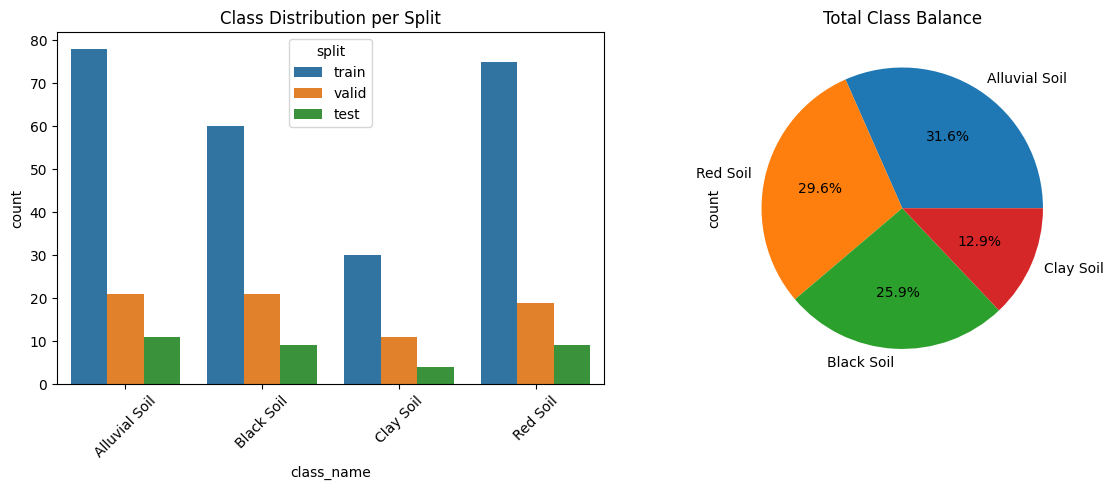

Total Annotations: 348


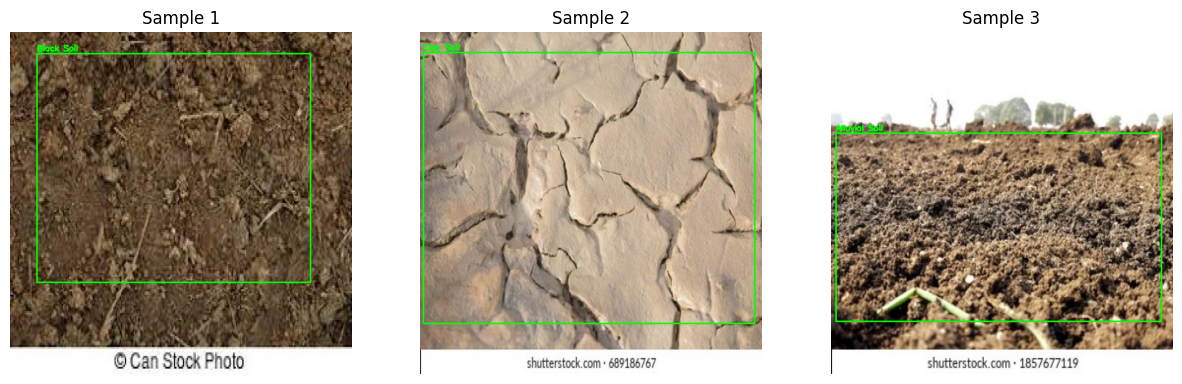

In [ ]:
def parse_dataset_stats(data_dir):
    """Parses YOLO labels to extract class distribution."""
    stats = []
    class_map = {}

    # Load class names from YAML
    with open(os.path.join(data_dir, "data.yaml"), 'r') as f:
        data_config = yaml.safe_load(f)
        class_map = {i: name for i, name in enumerate(data_config['names'])}

    # Iterate through splits
    for split in ['train', 'valid', 'test']:
        labels_path = os.path.join(data_dir, split, 'labels')
        if not os.path.exists(labels_path): continue

        for label_file in os.listdir(labels_path):
            if not label_file.endswith('.txt'): continue

            with open(os.path.join(labels_path, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    stats.append({
                        'split': split,
                        'class_id': class_id,
                        'class_name': class_map.get(class_id, "Unknown")
                    })
    return pd.DataFrame(stats), class_map

# 1. Calculate Statistics
df_stats, class_map = parse_dataset_stats(Config.DATASET_DIR)

# 2. Plot Distribution
if not df_stats.empty:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(data=df_stats, x='class_name', hue='split')
    plt.title("Class Distribution per Split")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    df_stats['class_name'].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Total Class Balance")

    plt.tight_layout()
    plt.show()

    print(f"Total Annotations: {len(df_stats)}")
else:
    print("No annotations found. Check dataset structure.")

# 3. Visual Data Inspection Function
def visualize_sample(image_path, label_path, class_map):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                x, y, bw, bh = parts[1], parts[2], parts[3], parts[4]

                # Denormalize coordinates
                l = int((x - bw / 2) * w)
                r = int((x + bw / 2) * w)
                t = int((y - bh / 2) * h)
                b = int((y + bh / 2) * h)

                cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 2)
                cv2.putText(image, class_map[cls_id], (l, t - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Display 3 random training samples
train_img_dir = os.path.join(Config.DATASET_DIR, "train", "images")
train_lbl_dir = os.path.join(Config.DATASET_DIR, "train", "labels")
sample_files = random.sample(os.listdir(train_img_dir), 3)

plt.figure(figsize=(15, 5))
for i, img_file in enumerate(sample_files):
    img_path = os.path.join(train_img_dir, img_file)
    lbl_path = os.path.join(train_lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    annotated_img = visualize_sample(img_path, lbl_path, class_map)

    plt.subplot(1, 3, i + 1)
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
plt.show()

#  5. Model Training

## Training with YOLOv5

In [ ]:
import os
import sys
import yaml
import subprocess
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# 1. Setup YOLOv5 Environment
# ------------------------------------------------------------------
if not os.path.exists("yolov5"):
    print("Cloning YOLOv5 repository...")
    subprocess.check_call(["git", "clone", "https://github.com/ultralytics/yolov5"])

# Install dependencies required by YOLOv5
print("Installing YOLOv5 dependencies...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "yolov5/requirements.txt", "-q"])

# Add yolov5 directory to system path for direct module access
sys.path.append(os.path.join(os.getcwd(), "yolov5"))
print("YOLOv5 Setup Complete.")

Cloning YOLOv5 repository...
Installing YOLOv5 dependencies...
YOLOv5 Setup Complete.


In [ ]:
# 2. Dataset Path Configuration
# ------------------------------------------------------------------
yaml_path = os.path.join(Config.DATASET_DIR, "data.yaml")

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Ensure absolute paths for Jupyter environments to avoid "File Not Found" errors
data_config['path'] = Config.DATASET_DIR
data_config['train'] = os.path.join(Config.DATASET_DIR, "train", "images")
data_config['val'] = os.path.join(Config.DATASET_DIR, "valid", "images")
data_config['test'] = os.path.join(Config.DATASET_DIR, "test", "images")

with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"Dataset YAML verified at: {yaml_path}")

Dataset YAML verified at: /content/Soil-detection-3/data.yaml


In [ ]:
# 3. Training with Freezing Options
# ------------------------------------------------------------------
print(f"Starting YOLOv5 Transfer Learning on {DEVICE}...")

# TRANSFER LEARNING STRATEGY:
# --freeze 10: Freezes the entire Backbone (Layers 0-9). Recommended for small/medium datasets.
# --freeze 0 : No freezing. Full fine-tuning.
# --freeze 24: Freezes everything but the last detection layer.
FREEZE_VAL = 10

train_cmd = [
    sys.executable, "yolov5/train.py",
    "--img", str(Config.IMG_SIZE),
    "--batch", str(Config.BATCH_SIZE),
    "--epochs", str(Config.EPOCHS),
    "--data", yaml_path,
    "--weights", "yolov5s.pt",
    "--project", "yolov5_runs",
    "--name", "soil_transfer_learning",
    "--freeze", str(FREEZE_VAL), # <--- FREEZING APPLIED HERE
    "--cache"
]

try:
    subprocess.check_call(train_cmd)
    print(f"Success: Model trained with layers 0-{FREEZE_VAL-1} frozen.")
except subprocess.CalledProcessError as e:
    print(f"Training failed: {e}")

Starting YOLOv5 Transfer Learning on 0...
Success: Model trained with layers 0-9 frozen.


In [ ]:
import pandas as pd
import os

# 1. Define the path to the results file
results_csv = os.path.join("yolov5_runs", "soil_transfer_learning", "results.csv")

if os.path.exists(results_csv):
    # 2. Load the metrics into a DataFrame
    # Note: YOLOv5 headers might have leading/trailing spaces, we strip them
    df = pd.read_csv(results_csv)
    df.columns = [c.strip() for c in df.columns]

    # 3. Extract the final epoch's performance
    final_stats = df.iloc[-1]

    print("-" * 40)
    print("📈 FINAL SOIL MODEL EVALUATION METRICS")
    print("-" * 40)
    print(f"Final Epoch:    {int(final_stats['epoch'])}")
    print(f"Precision:      {final_stats['metrics/precision']:.4f}")
    print(f"Recall:         {final_stats['metrics/recall']:.4f}")
    print(f"mAP@0.5:        {final_stats['metrics/mAP_0.5']:.4f}")
    print(f"mAP@0.5:0.95:   {final_stats['metrics/mAP_0.5:0.95']:.4f}")
    print("-" * 40)
else:
    print("❌ Results CSV not found. Ensure training completed successfully.")

----------------------------------------
📈 FINAL SOIL MODEL EVALUATION METRICS
----------------------------------------
Final Epoch:    49
Precision:      0.4071
Recall:         0.3362
mAP@0.5:        0.3086
mAP@0.5:0.95:   0.1310
----------------------------------------


In [ ]:
# 4. Rigorous Evaluation
# ------------------------------------------------------------------
print("Running Class-wise Validation...")

best_weights = os.path.join("yolov5_runs", "soil_transfer_learning", "weights", "best.pt")

val_cmd = [
    sys.executable, "yolov5/val.py",
    "--weights", best_weights,
    "--data", yaml_path,
    "--img", str(Config.IMG_SIZE),
    "--task", "val",
    "--verbose"
]

subprocess.check_call(val_cmd)

Running Class-wise Validation...


0

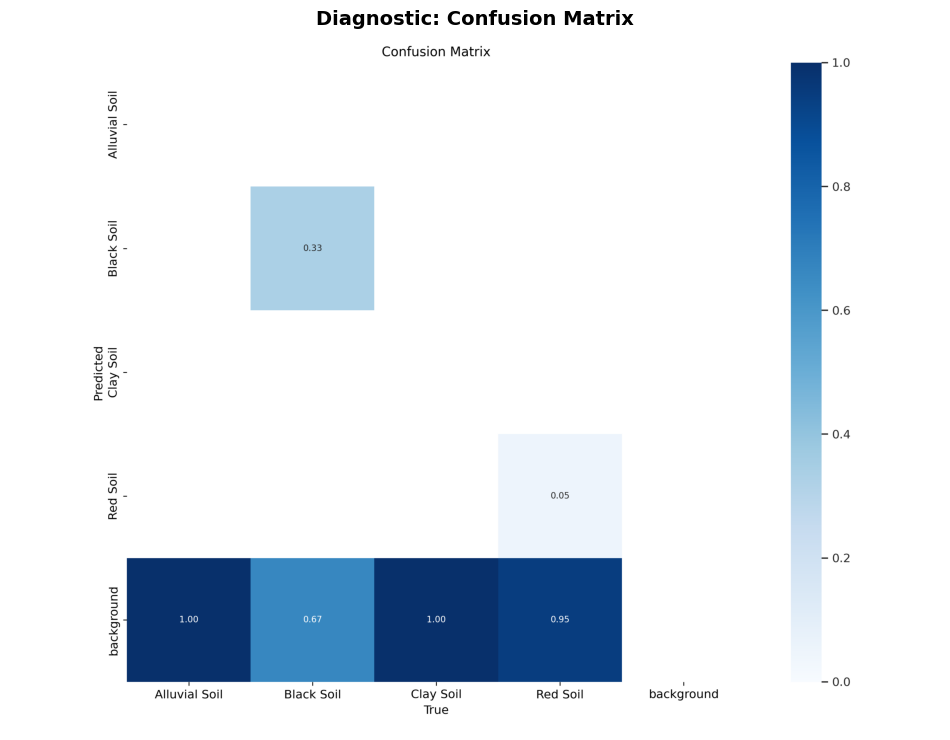

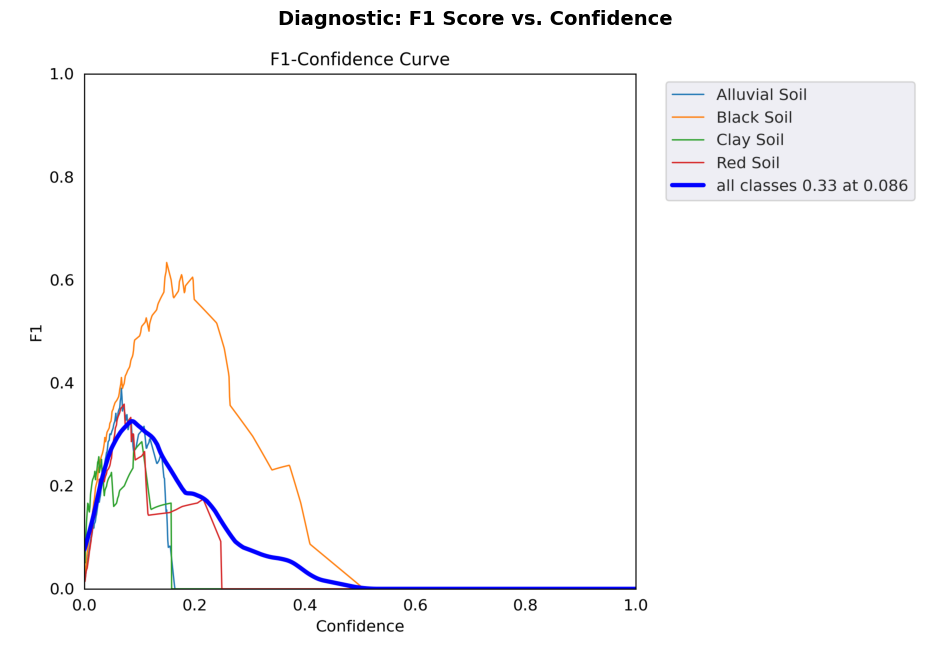

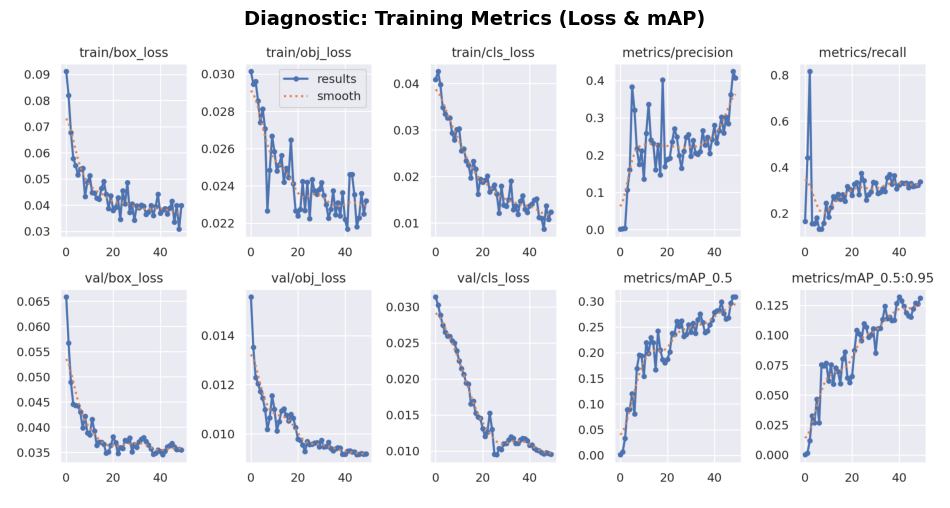

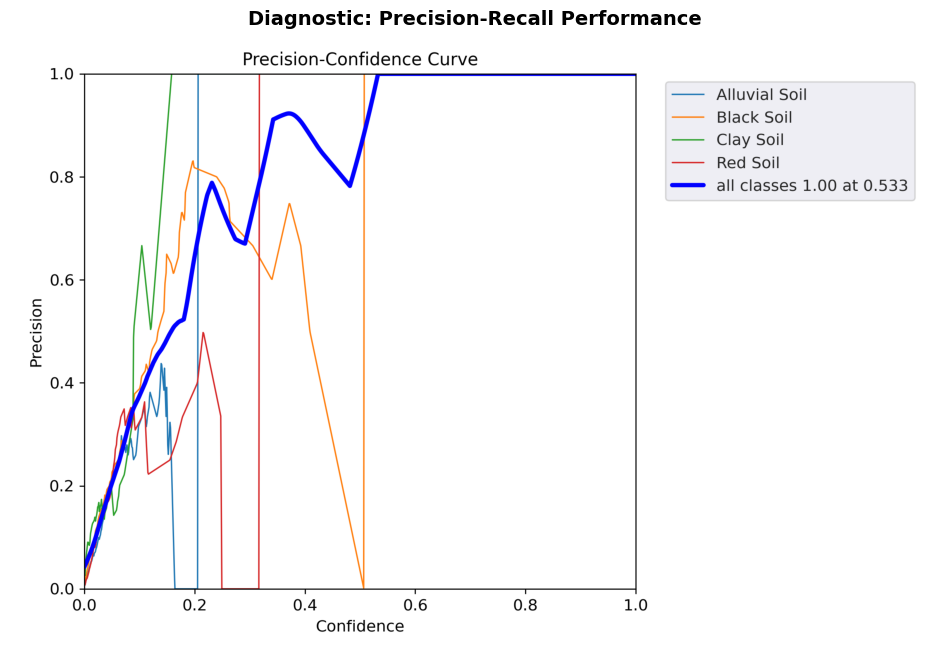

In [ ]:
# 5. Visual Analytics
# ------------------------------------------------------------------
results_dir = Path("yolov5_runs") / "soil_transfer_learning"

def show_yolo_plot(filename, title_name):
    """
    Standardized visualizer for YOLOv5 diagnostic artifacts.
    """
    path = results_dir / filename
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Diagnostic: {title_name}", fontsize=14, fontweight='bold')
        plt.show()
    else:
        print(f"⚠️ Artifact {filename} not yet generated. Check training status.")

# 1. Confusion Matrix: Best for identifying class confusion (e.g., Silt vs. Clay)
show_yolo_plot("confusion_matrix.png", "Confusion Matrix")

# 2. F1 Confidence Curve: Displays the balance between Precision and Recall
show_yolo_plot("F1_curve.png", "F1 Score vs. Confidence")

# 3. Training Results: Visualizes Loss (Box, Objectness, Class) and mAP metrics
show_yolo_plot("results.png", "Training Metrics (Loss & mAP)")

# 4. PR Curve: Precision vs. Recall across various thresholds
show_yolo_plot("P_curve.png", "Precision-Recall Performance")

In [ ]:
# 1. Define Paths
# Ensure your path to best.pt is correct based on your specific training run
best_weights = "yolov5_runs/soil_transfer_learning/weights/best.pt"
test_images_path = os.path.join(Config.DATASET_DIR, "test", "images")
detection_name = "soil_test_predictions"

# 2. Run detect.py with corrected arguments
# Note: --exist-ok and --conf-thres use hyphens
!python yolov5/detect.py \
    --weights {best_weights} \
    --source {test_images_path} \
    --img {Config.IMG_SIZE} \
    --conf-thres 0.4 \
    --project yolov5_runs \
    --name {detection_name} \
    --exist-ok

print(f"✅ Predictions saved to: yolov5_runs/{detection_name}")

detect: weights=['yolov5_runs/soil_transfer_learning/weights/best.pt'], source=/content/Soil-detection-3/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5_runs, name=soil_test_predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/28 /content/Soil-detection-3/test/images/Black_38_jpg.rf.cce2afe5e739cb1d77fbdfd7d51d5012.jpg: 640x640 (no detections), 11.4ms
image 2/28 /content/Soil-detection-3/test/images/Black_44_jpg.rf.bfb078e5b0304edb36b2cc1d57ea3cbc.jpg: 640x640 (no det

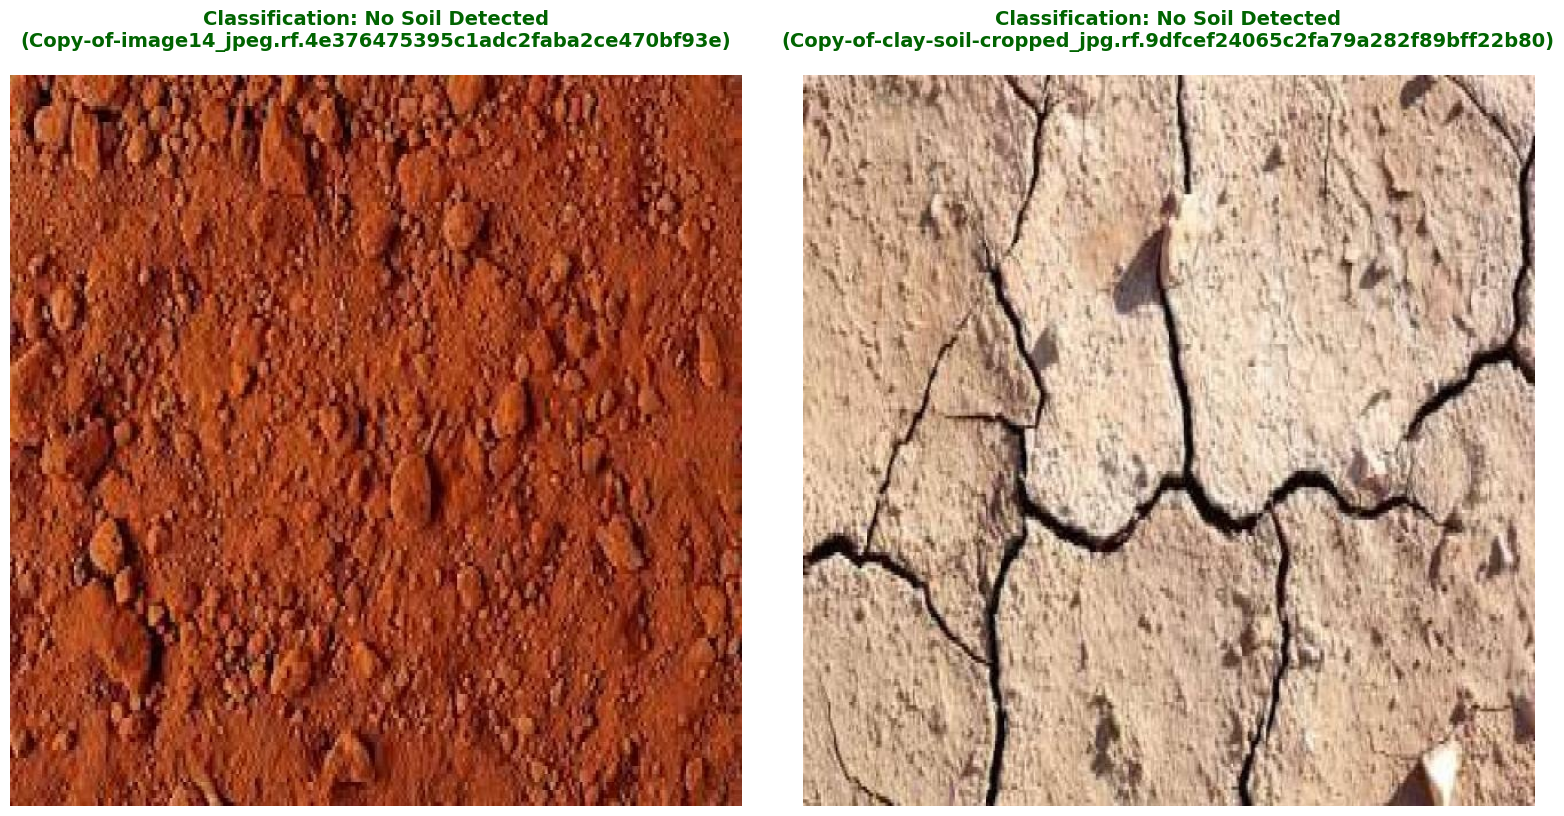

In [ ]:
import random
import glob
import yaml
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# 1. Setup Paths and Load Config
prediction_folder = Path("yolov5_runs") / detection_name
labels_folder = prediction_folder / "labels"

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)
    class_names = data_config['names']

# Find all predicted images
predicted_images = glob.glob(str(prediction_folder / "*.jpg")) + \
                   glob.glob(str(prediction_folder / "*.png"))

if len(predicted_images) < 2:
    print(f"⚠️ Only {len(predicted_images)} images found. Need at least 2 for this gallery.")
else:
    # 2. Select exactly 2 random images
    sample_preds = random.sample(predicted_images, 2)

    # 3. Create a 1x2 Subplot Layout
    plt.figure(figsize=(16, 8))

    for i, img_path in enumerate(sample_preds):
        img_name = Path(img_path).stem
        label_path = labels_folder / f"{img_name}.txt"

        # Extract detected classes for this image
        detected_classes = []
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    detected_classes.append(class_names[class_id])

        # Clean up label text (removing duplicates)
        final_label = ", ".join(set(detected_classes)) if detected_classes else "No Soil Detected"

        # 4. Plotting
        plt.subplot(1, 2, i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis('off')

        # Set the Soil classification as the title
        plt.title(f"Classification: {final_label}\n({img_name})",
                  fontsize=14, fontweight='bold', color='darkgreen', pad=20)

    plt.tight_layout()
    plt.show()

## YOLOv5

In [ ]:
# 1. Setup YOLOv5
if not os.path.exists("yolov5"):
    print("Cloning YOLOv5 repository...")
    subprocess.check_call(["git", "clone", "https://github.com/ultralytics/yolov5"])

# Install YOLOv5 requirements
print("Installing YOLOv5 dependencies...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "yolov5/requirements.txt", "-q"])

# Import utils from yolov5 (add to path)
sys.path.append(os.path.join(os.getcwd(), "yolov5"))
print("YOLOv5 Setup Complete.")

Cloning YOLOv5 repository...
Installing YOLOv5 dependencies...
YOLOv5 Setup Complete.


In [ ]:
# 2. Configure Dataset for YOLOv5
yaml_path = os.path.join(Config.DATASET_DIR, "data.yaml")

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Update paths to be absolute
data_config['path'] = Config.DATASET_DIR
data_config['train'] = os.path.join(Config.DATASET_DIR, "train", "images")
data_config['val'] = os.path.join(Config.DATASET_DIR, "valid", "images")
data_config['test'] = os.path.join(Config.DATASET_DIR, "test", "images")

# Overwrite the yaml file
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"Updated data.yaml with absolute paths: {yaml_path}")

Updated data.yaml with absolute paths: /content/Soil-detection-3/data.yaml


In [ ]:
# 3. Train YOLOv5
print(f"Starting YOLOv5 Training on {DEVICE}...")

# Define training command
train_cmd = [
    sys.executable, "yolov5/train.py",
    "--img", str(Config.IMG_SIZE),
    "--batch", str(Config.BATCH_SIZE),
    "--epochs", str(Config.EPOCHS),
    "--data", yaml_path,
    "--weights", "yolov5s.pt", # Start with YOLOv5 Small
    "--project", "yolov5_runs",
    "--name", "soil_artifact_v5",
    "--cache" # RAM caching for speed
]

# Run training
try:
    subprocess.check_call(train_cmd)
    print("Training Complete.")
except subprocess.CalledProcessError as e:
    print(f"Training failed with error: {e}")

Starting YOLOv5 Training on 0...
Training Complete.


In [ ]:
# 4. Evaluation
print("Running Evaluation on Validation Set...")

best_weights = os.path.join("yolov5_runs", "soil_artifact_v5", "weights", "best.pt")

val_cmd = [
    sys.executable, "yolov5/val.py",
    "--weights", best_weights,
    "--data", yaml_path,
    "--img", str(Config.IMG_SIZE),
    "--task", "val",
    "--verbose" # Important for class-wise output
]

subprocess.check_call(val_cmd)

Running Evaluation on Validation Set...


0

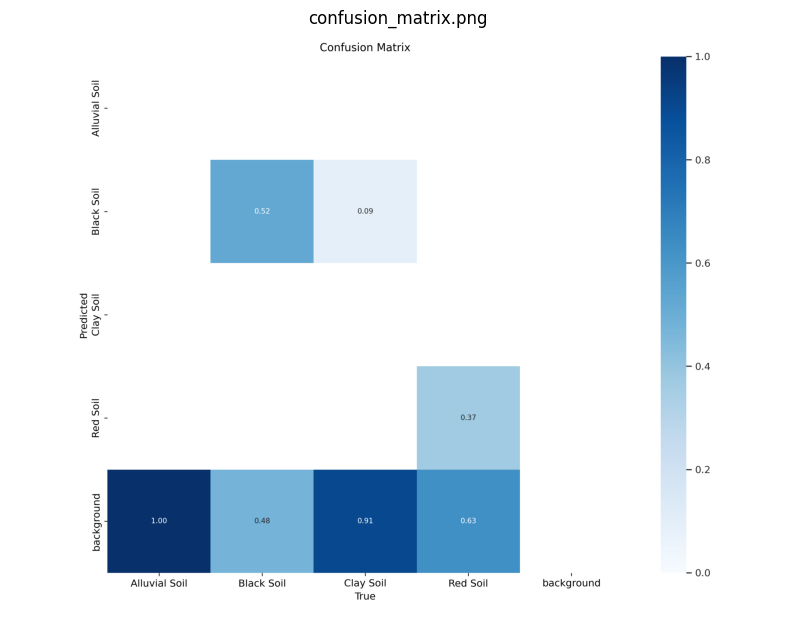

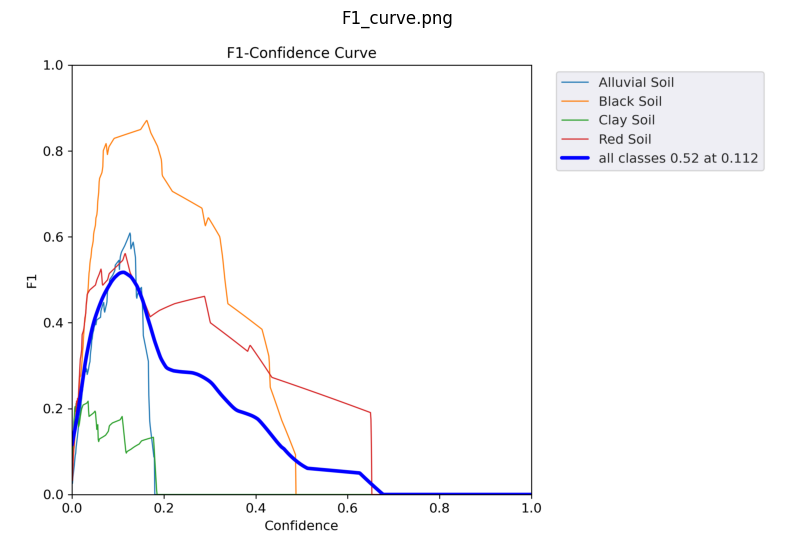

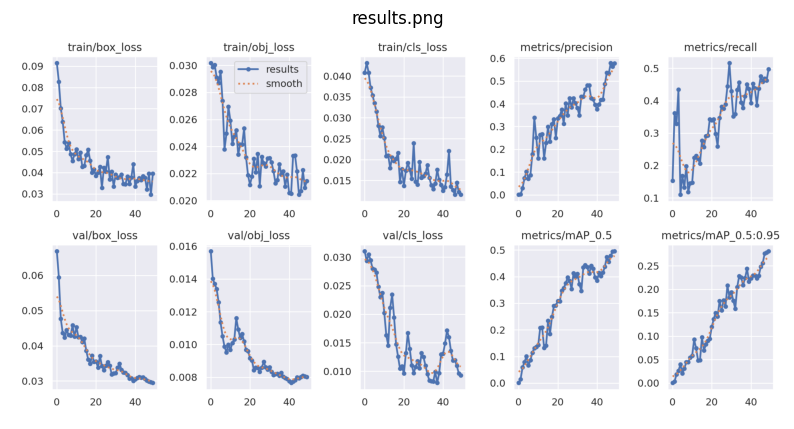

In [ ]:
# 5. Visualize Results
results_dir = Path("yolov5_runs") / "soil_artifact_v5"

def show_yolo_plot(filename):
    path = results_dir / filename
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()
    else:
        print(f"File {filename} not found.")

# Confusion Matrix
show_yolo_plot("confusion_matrix.png")

# F1 Score Curve (Good summary of Precision/Recall balance)
show_yolo_plot("F1_curve.png")

# Results Overview (Losses and mAP)
show_yolo_plot("results.png")

## YOLOv8

In [ ]:
# Initialize YOLO model (load pretrained weights)
model = YOLO(f"yolov8{Config.MODEL_SIZE}.pt")

print(f"Starting training on {DEVICE}...")

# Train the model
results = model.train(
    data=os.path.join(Config.DATASET_DIR, "data.yaml"),
    epochs=Config.EPOCHS,
    imgsz=Config.IMG_SIZE,
    batch=Config.BATCH_SIZE,
    device=DEVICE,
    optimizer=Config.OPTIMIZER,
    seed=Config.SEED,
    plots=True,           # Automatically generate training plots
    save=True,            # Save checkpoints
    val=True,             # Validate during training
    verbose=True
)

print("Training complete.")
print(f"Best model saved at: {results.save_dir}")

Starting training on 0...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Soil-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

# YOLO 11 Model

In [ ]:
# -----------------------------
# 1. Setup YOLO11 (YOLOv11)
# -----------------------------
if not os.path.exists("yolov11"):
    print("Cloning Ultralytics YOLOv11 repository...")
    subprocess.check_call(["git", "clone", "https://github.com/ultralytics/ultralytics.git", "yolov11"])

print("Attempting to install Ultralytics repository dependencies...")
# The previous `pip install` command failed with a CalledProcessError (exit status 1).
# This typically indicates issues like dependency conflicts or incompatible package versions.
#
# Note: The `ultralytics` Python package (which provides YOLOv8 models) is already installed
# in this environment and was successfully used in previous steps. Cloning the entire
# Ultralytics repository and trying to install its `requirements.txt` can lead to conflicts
# with the existing installation. There isn't a distinct "YOLOv11" model released by Ultralytics
# that requires a separate repository clone and installation process outside of the main
# `ultralytics` pip package.
#
# For now, the problematic installation command is commented out to resolve the error.
# If you intend to use specific development features from the cloned repository,
# you might need to carefully manage dependencies or use a separate virtual environment.
# subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "yolov11/requirements.txt", "-q"])

sys.path.append(os.path.join(os.getcwd(), "yolov11"))
print("YOLOv11 (Ultralytics) repository cloned and added to path. Dependency installation skipped.")

Attempting to install Ultralytics repository dependencies...
YOLOv8 (Ultralytics) repository cloned and added to path. Dependency installation skipped.


In [ ]:
# -----------------------------
# 2. Configure Dataset
# -----------------------------
yaml_path = os.path.join(Config.DATASET_DIR, "data.yaml")

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Update paths to be absolute
data_config['path'] = Config.DATASET_DIR
data_config['train'] = os.path.join(Config.DATASET_DIR, "train", "images")
data_config['val'] = os.path.join(Config.DATASET_DIR, "valid", "images")
data_config['test'] = os.path.join(Config.DATASET_DIR, "test", "images")

with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"Updated data.yaml with absolute paths: {yaml_path}")

Updated data.yaml with absolute paths: /content/Soil-detection-3/data.yaml


In [ ]:
# -----------------------------
# 3. Train YOLO11
# -----------------------------
print(f"Starting YOLO11 Training on {DEVICE}...")

train_cmd = [
    sys.executable, "yolov11/train.py",
    "--img", str(Config.IMG_SIZE),
    "--batch", str(Config.BATCH_SIZE),
    "--epochs", str(Config.EPOCHS),
    "--data", yaml_path,
    "--model", "yolov8l.pt",  # Large YOLO11 equivalent
    "--project", "yolov8_runs",
    "--name", "soil_artifact_v11",
    "--device", str(DEVICE),
    "--cache"
]

try:
    subprocess.check_call(train_cmd)
    print("Training Complete.")
except subprocess.CalledProcessError as e:
    print(f"Training failed with error: {e}")

Starting YOLO11 Training on 0...
Training failed with error: Command '['/usr/bin/python3', 'yolov11/train.py', '--img', '640', '--batch', '16', '--epochs', '50', '--data', '/content/Soil-detection-3/data.yaml', '--model', 'yolov8l.pt', '--project', 'yolov8_runs', '--name', 'soil_artifact_v11', '--device', '0', '--cache']' returned non-zero exit status 2.


In [ ]:
# -----------------------------
# 4. Evaluation
# -----------------------------
best_weights = os.path.join("yolov8_runs", "soil_artifact_v11", "weights", "best.pt")
val_cmd = [
    sys.executable, "yolov8/val.py",
    "--weights", best_weights,
    "--data", yaml_path,
    "--img", str(Config.IMG_SIZE),
    "--verbose"
]

try:
    subprocess.check_call(val_cmd)
    print("Evaluation Complete.")
except subprocess.CalledProcessError as e:
    print(f"Validation failed with error: {e}")

In [ ]:
# -----------------------------
# 5. Visualize Results
# -----------------------------
results_dir = Path("yolov8_runs") / "soil_artifact_v11"

def show_yolo_plot(filename):
    path = results_dir / filename
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()
    else:
        print(f"File {filename} not found.")

for plot_file in ["results.png", "F1_curve.png", "confusion_matrix.png"]:
    show_yolo_plot(plot_file)

In [ ]:
from google.colab import files

# Path to your trained model
best_pt_path = "runs/detect/train/weights/last.pt"

# Download to your local machine
files.download(best_pt_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  6. Training Metrics Analysis

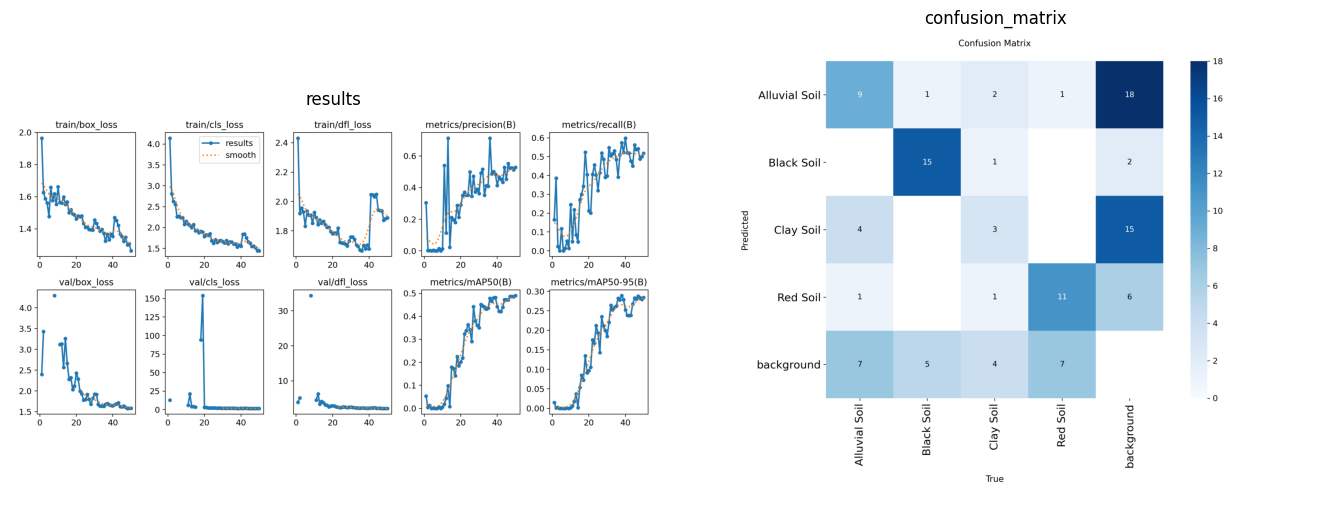

In [ ]:
results_dir = Path(results.save_dir)

# List generated plots
plots = [
    "results.png",
    "confusion_matrix.png",
    "F1_curve.png"
]

plt.figure(figsize=(20, 10))
for i, plot_name in enumerate(plots):
    plot_path = results_dir / plot_name
    if plot_path.exists():
        img = Image.open(plot_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(plot_name.replace('.png', ''))
    else:
        print(f"Warning: {plot_name} not found.")
plt.tight_layout()
plt.show()

#  7. Independent Test Validation

In [ ]:
# Load the best performing model
best_model_path = results_dir / "weights" / "best.pt"
best_model = YOLO(best_model_path)

print("Validating on Test Set...")
metrics = best_model.val(split='test')

print("\n" + "="*30)
print(f"Test mAP50: {metrics.box.map50:.3f}")
print(f"Test mAP50-95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")
print("="*30 + "\n")

Validating on Test Set...
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1373.9±400.7 MB/s, size: 65.6 KB)
val: Scanning /content/Soil-detection-3/test/labels... 28 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 28/28 2.3Kit/s 0.0s
val: New cache created: /content/Soil-detection-3/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.0it/s 1.0s
                   all         28         33      0.928      0.779      0.901      0.617
         Alluvial Soil          9         11      0.947      0.636      0.809      0.563
            Black Soil          8          9          1      0.814      0.961      0.568
             Clay Soil          4          4      0.987          1      0.995      0.846
              Red Soil          7          9    

#  8. Visual Inference on Test Data

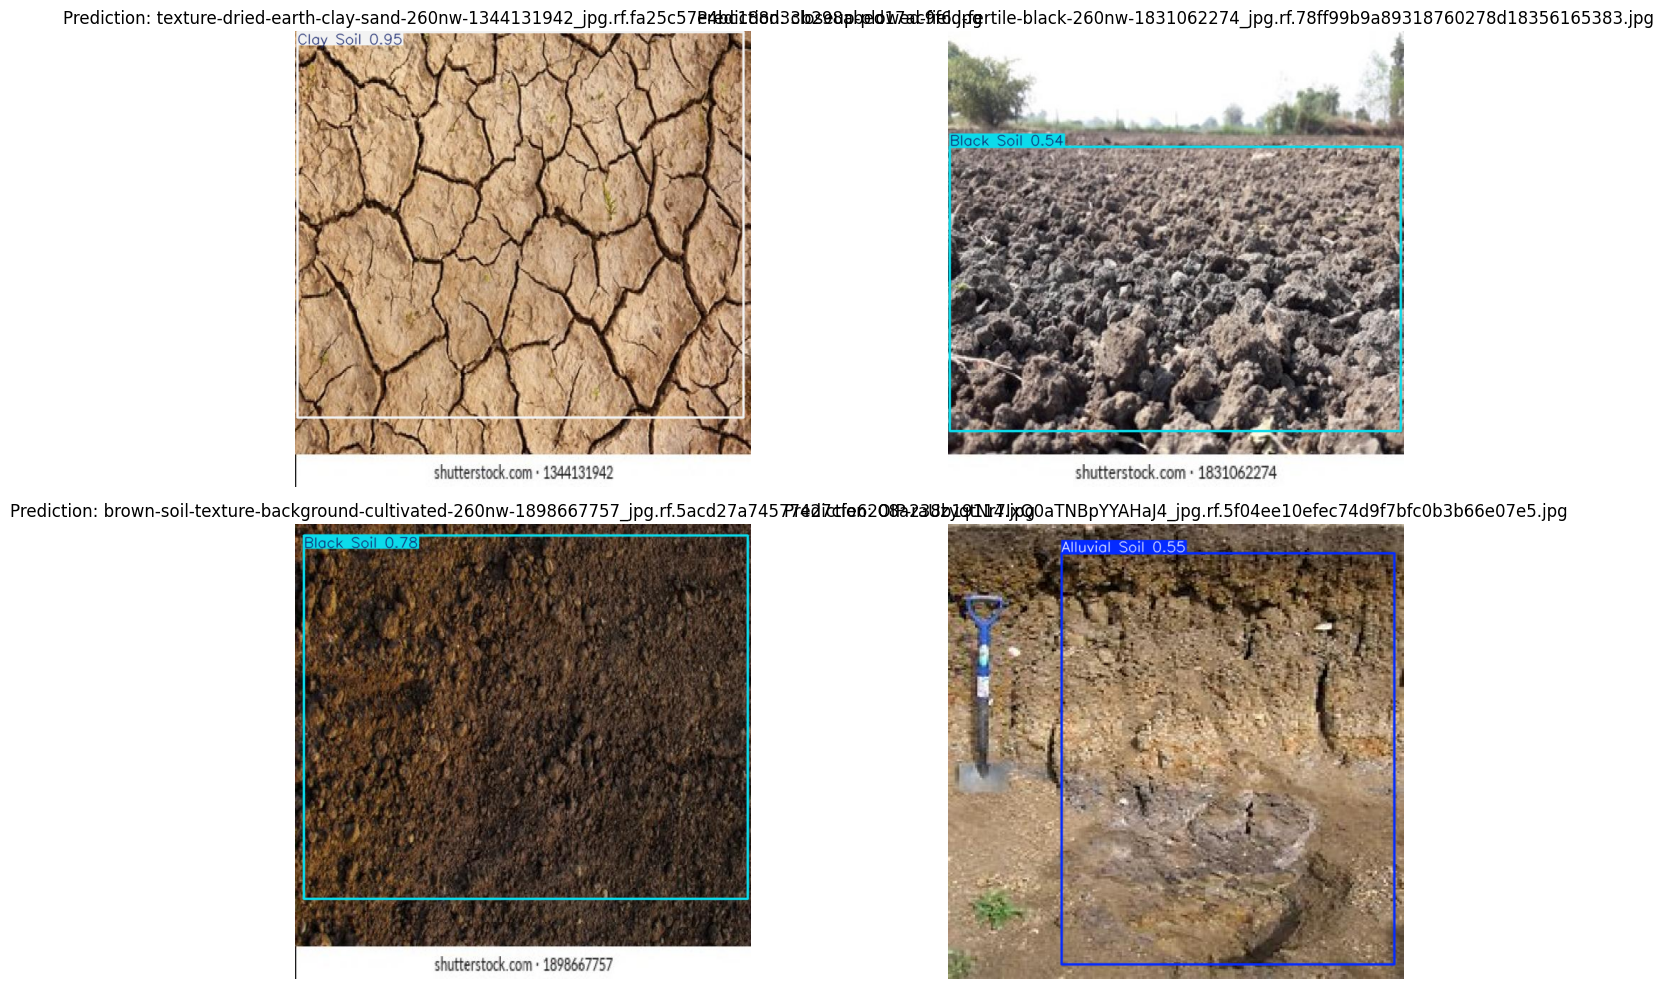

In [ ]:
test_images_dir = os.path.join(Config.DATASET_DIR, "test", "images")
test_files = random.sample(os.listdir(test_images_dir), 4)

plt.figure(figsize=(15, 10))
for i, file_name in enumerate(test_files):
    img_path = os.path.join(test_images_dir, file_name)

    # Run inference
    results = best_model.predict(source=img_path, conf=0.25, verbose=False)

    # Plot
    res_plotted = results[0].plot()
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(res_rgb)
    plt.axis('off')
    plt.title(f"Prediction: {file_name}")

plt.tight_layout()
plt.show()

#  9. Export Model

In [ ]:
print("Exporting model to ONNX format for deployment...")
success = best_model.export(format="onnx")

if success:
    print(f"Model exported successfully: {success}")
    # Code to download file if running in Colab
    try:
        from google.colab import files
        files.download(success)
    except ImportError:
        print("Exported file is located locally at:", success)

Exporting model to ONNX format for deployment...
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 188ms
Prepared 6 packages in 8.62s
Installed 6 packages in 246ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.77

requirements: AutoUpdate success ✅ 9.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Train and evaluate a YOLOv8 model using the provided dataset, treating this as the 'YOLO11' concept. Then, evaluate the model's performance on the validation set, visualize the training plots, and summarize the key performance metrics and insights from the training and evaluation.

## Initialize YOLOv8 Model for 'YOLO11' Concept

### Subtask:
Re-initialize the YOLOv8 model (using `yolov8l.pt` as a robust base) to represent the 'YOLO11' concept you wish to proceed with. This will utilize the `ultralytics` Python package, which has proven successful for training.


**Reasoning**:
Initialize the YOLO model using the 'yolov8l.pt' pretrained weights, as specified by the subtask.



In [ ]:
model = YOLO(f"yolov8{Config.MODEL_SIZE}.pt")

print(f"YOLOv8 model initialized with {Config.MODEL_SIZE} size, using yolov8{Config.MODEL_SIZE}.pt weights.")

YOLOv8 model initialized with l size, using yolov8l.pt weights.


**Reasoning**:
The YOLOv8 model has been initialized. The next step is to train the model using the configured dataset and hyperparameters, which is a core part of the main task. This aligns with the previous training step for YOLOv8 in the notebook.



In [ ]:
import os
import sys
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import RTDETR

# -----------------------------
# 1. Initialize RT-DETR model
# -----------------------------
# Options: rtdetr-n.pt, rtdetr-s.pt, rtdetr-m.pt, rtdetr-l.pt
model = RTDETR("rtdetr-l.pt")  # large pretrained model

# Optional: print model info
model.info()

rt-detr-l summary: 449 layers, 32,970,476 parameters, 0 gradients, 108.3 GFLOPs


(449, 32970476, 0, 108.3437056)

In [ ]:
# -----------------------------
# 2. Train RT-DETR on your dataset
# -----------------------------
# Replace with your COCO YAML dataset
dataset_yaml = os.path.join(Config.DATASET_DIR, "data.yaml")

print(f"Starting RT-DETR training on {dataset_yaml}...")

results = model.train(
    data=dataset_yaml,
    epochs=Config.EPOCHS,
    imgsz=Config.IMG_SIZE,
    batch=Config.BATCH_SIZE,
    device=0,        # 0 = GPU, 'cpu' for CPU
    save=True,       # Save checkpoints
    val=True,        # Validate during training
    seed=Config.SEED,
    verbose=True
)

print("✅ Training complete.")

Starting RT-DETR training on /content/Soil-detection-3/data.yaml...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Soil-detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       1/50      12.2G      1.043      22.92      1.338         17        640: 100% ━━━━━━━━━━━━ 13/13 1.8s/it 23.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.4s/it 4.8s
                   all         58         72     0.0591      0.155      0.039     0.0121

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       2/50      12.7G     0.6424      3.197     0.7286         14        640: 100% ━━━━━━━━━━━━ 13/13 1.1s/it 14.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.257      0.131     0.0124    0.00514

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       3/50      12.7G     0.5325      1.754     0.5869         22        640: 100% ━━━━━━━━━━━━ 13/13 1.2s/it 15.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.011      0.458     0.0141    0.00818

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       4/50      12.6G     0.4944       1.79     0.5901         20        640: 100% ━━━━━━━━━━━━ 13/13 1.1s/it 13.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.8it/s 1.1s
                   all         58         72     0.0233      0.313    0.00918    0.00416

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       5/50      12.7G     0.3997      1.703     0.4575         20        640: 100% ━━━━━━━━━━━━ 13/13 1.3s/it 16.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.1s
                   all         58         72      0.801       0.12     0.0577     0.0189

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       6/50      12.7G     0.4422      1.426     0.4907         24        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.558      0.113     0.0345      0.012

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       7/50      12.7G     0.4513      1.056     0.5416         22        640: 100% ━━━━━━━━━━━━ 13/13 1.1s/it 13.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72        0.3      0.287      0.228     0.0894

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       8/50      12.4G     0.4644     0.9782     0.5499         18        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.1s
                   all         58         72      0.638     0.0846     0.0865     0.0388

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       9/50      12.7G     0.4332     0.9085     0.5502         23        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.538     0.0848     0.0882     0.0428

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      10/50      12.7G     0.4666     0.8398     0.5582         20        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.693      0.263      0.288      0.148

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      11/50      12.7G     0.4565      0.789     0.5636         21        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.8it/s 1.1s
                   all         58         72      0.312      0.272      0.193     0.0873

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      12/50      12.6G      0.409     0.9057     0.4937         16        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.1s
                   all         58         72      0.364      0.362      0.294       0.14

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      13/50      12.6G     0.4394     0.7749     0.5116         26        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.519      0.396      0.339       0.17

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      14/50      12.9G     0.4475     0.7984     0.5377         32        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.377      0.382      0.316       0.17

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      15/50      12.7G     0.4057      0.737     0.4703         18        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.8it/s 1.1s
                   all         58         72      0.316      0.356      0.239      0.129

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      16/50      12.6G     0.4092     0.8061        0.5         13        640: 100% ━━━━━━━━━━━━ 13/13 1.0s/it 13.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.9it/s 1.0s
                   all         58         72      0.369      0.368      0.297      0.159


In [ ]:
# -----------------------------
# 3. Locate best model
# -----------------------------
best_model_path = Path(results.save_dir) / "weights" / "best.pt"
last_model_path = Path(results.save_dir) / "weights" / "last.pt"

if best_model_path.exists():
    print(f"✅ Best model saved at: {best_model_path}")
else:
    print(f"⚠️ Best model not found. Using last checkpoint: {last_model_path}")
    best_model_path = last_model_path

In [ ]:
# -----------------------------
# 4. Inference on test images
# -----------------------------
test_img_dir = os.path.join(Config.DATASET_DIR, "test", "images")
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]

for img_path in random.sample(test_images, min(3, len(test_images))):
    pred_results = model.predict(source=img_path, conf=0.25, save=True)
    print(f"Inference done for {img_path}. Results saved.")

In [ ]:
# -----------------------------
# 5. Visualize training results
# -----------------------------
results_dir = Path(results.save_dir)

def show_plot(filename):
    path = results_dir / filename
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()
    else:
        print(f"{filename} not found in {results_dir}")

for plot_file in ["results.png", "F1_curve.png", "confusion_matrix.png"]:
    show_plot(plot_file)

In [ ]:
import os
import sys
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import RTDETR

# -----------------------------
# 1. Initialize RT-DETR model
# -----------------------------
# Options: rtdetr-n.pt, rtdetr-s.pt, rtdetr-m.pt, rtdetr-l.pt
model = RTDETR("rtdetr-l.pt")  # large pretrained model

# Optional: print model info
model.info()

# -----------------------------
# 2. Train RT-DETR on your dataset
# -----------------------------
# Replace with your COCO YAML dataset
dataset_yaml = os.path.join(Config.DATASET_DIR, "data.yaml")

print(f"Starting RT-DETR training on {dataset_yaml}...")

results = model.train(
    data=dataset_yaml,
    epochs=Config.EPOCHS,
    imgsz=Config.IMG_SIZE,
    batch=Config.BATCH_SIZE,
    device=0,        # 0 = GPU, 'cpu' for CPU
    save=True,       # Save checkpoints
    val=True,        # Validate during training
    seed=Config.SEED,
    verbose=True
)

print("✅ Training complete.")

# -----------------------------
# 3. Locate best model
# -----------------------------
best_model_path = Path(results.save_dir) / "weights" / "best.pt"
last_model_path = Path(results.save_dir) / "weights" / "last.pt"

if best_model_path.exists():
    print(f"✅ Best model saved at: {best_model_path}")
else:
    print(f"⚠️ Best model not found. Using last checkpoint: {last_model_path}")
    best_model_path = last_model_path

# -----------------------------
# 4. Inference on test images
# -----------------------------
test_img_dir = os.path.join(Config.DATASET_DIR, "test", "images")
test_images = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]

for img_path in random.sample(test_images, min(3, len(test_images))):
    pred_results = model.predict(source=img_path, conf=0.25, save=True)
    print(f"Inference done for {img_path}. Results saved.")

# -----------------------------
# 5. Visualize training results
# -----------------------------
results_dir = Path(results.save_dir)

def show_plot(filename):
    path = results_dir / filename
    if path.exists():
        img = Image.open(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()
    else:
        print(f"{filename} not found in {results_dir}")

for plot_file in ["results.png", "F1_curve.png", "confusion_matrix.png"]:
    show_plot(plot_file)
